In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter



# Process Data

In [ ]:

jobs = pd.read_csv("fake_job_postings.csv")
print(f'Shape of the data frame: {jobs.shape} ')
print("=== INFO ===")
print(jobs.info())
print("\n=== HEAD ===")
print(jobs.head())




Shape of the data frame: (17880, 18) 
=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  in

# Missing values

In [ ]:
missing = jobs.isna().sum().sort_values(ascending=False)
missing_pct = (jobs.isna().mean()*100).sort_values(ascending=False)
missing_df = pd.DataFrame({"Missing Count": missing,"Missing %": missing_pct.round(2)})
print(f"missing_df: {missing_df}")

missing_df:                      Missing Count  Missing %
salary_range                 15012      83.96
department                   11547      64.58
required_education            8105      45.33
benefits                      7212      40.34
required_experience           7050      39.43
function                      6455      36.10
industry                      4903      27.42
employment_type               3471      19.41
company_profile               3308      18.50
requirements                  2696      15.08
location                       346       1.94
description                      1       0.01
job_id                           0       0.00
telecommuting                    0       0.00
has_questions                    0       0.00
has_company_logo                 0       0.00
title                            0       0.00
fraudulent                       0       0.00


# Categorical vs String vs Numeric

In [5]:
categorical = jobs.select_dtypes(include=['object']).columns.tolist()
numeric = jobs.select_dtypes(include=['int64','float64']).columns.tolist()

print("Categorical columns:", categorical)
print("\nNumeric columns:", numeric)

Categorical columns: ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

Numeric columns: ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


In [6]:
for col in categorical:
    if col in jobs.columns:
        print(f"\n=== {col} ===")
        print(jobs[col].value_counts(dropna=False).head(15))


=== title ===
title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Beauty & Fragrance consultants needed                  60
Graduates: English Teacher Abroad                      57
Customer Service Representative                        51
Administrative Assistant                               48
Product Manager                                        47
Name: count, dtype: int64

=== location ===
location
GB, LND, London          718
US, NY, New York         65

In [ ]:
# target variable 
print("Fraudulent job postings distribution:")
print(jobs["fraudulent"].value_counts(normalize=True)*100) 

In [ ]:
# Length analysis
jobs["description_len"] = jobs["description"].astype(str).apply(len)
jobs["requirements_len"] = jobs["requirements"].astype(str).apply(len)
jobs["company_profile_len"] = jobs["company_profile"].astype(str).apply(len)

jobs[["description_len","requirements_len","company_profile_len"]].describe()


In [ ]:
# Text lengths between real and fake jobs

jobs.groupby("fraudulent")[["description_len", "requirements_len", "company_profile_len"]].mean()


In [ ]:
# Duplicate


jobs.duplicated().sum()
jobs["title"].value_counts().head(20)


In [ ]:
# correlation in numeric


jobs.corr(numeric_only=True)



In [ ]:
#Suspicious Pattern Exploration

pd.crosstab(jobs["has_company_logo"], jobs["fraudulent"], normalize='index')
pd.crosstab(jobs["telecommuting"], jobs["fraudulent"], normalize='index')
jobs["benefits_missing"] = jobs["benefits"].isna().astype(int)
pd.crosstab(jobs["benefits_missing"], jobs["fraudulent"], normalize='index')


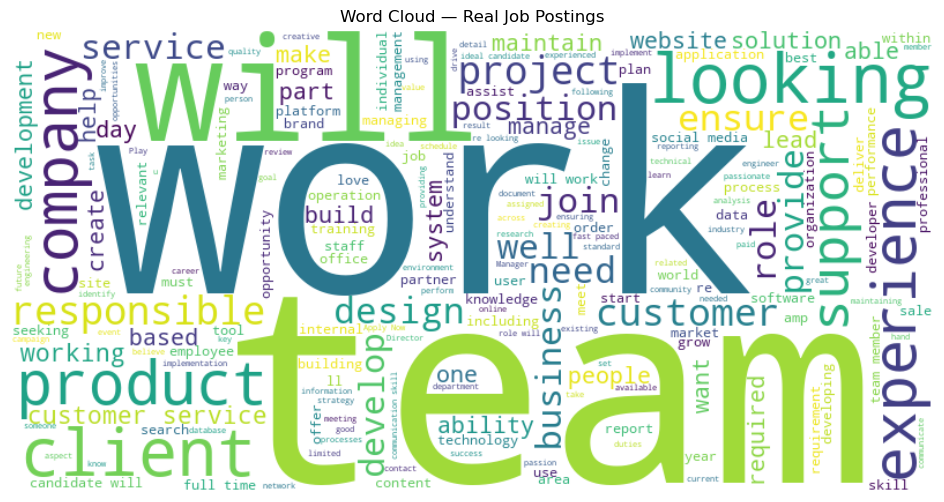

In [ ]:
# Word Cloud for Real Job
jobs['description'] = jobs['description'].fillna("")

real_jobs = jobs[jobs['fraudulent'] == 0]['description']
fake_jobs = jobs[jobs['fraudulent'] == 1]['description']

real_text = " ".join(real_jobs)

wc_real = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200
).generate(real_text)

plt.figure(figsize=(14,6))
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud — Real Job Postings")
plt.show()

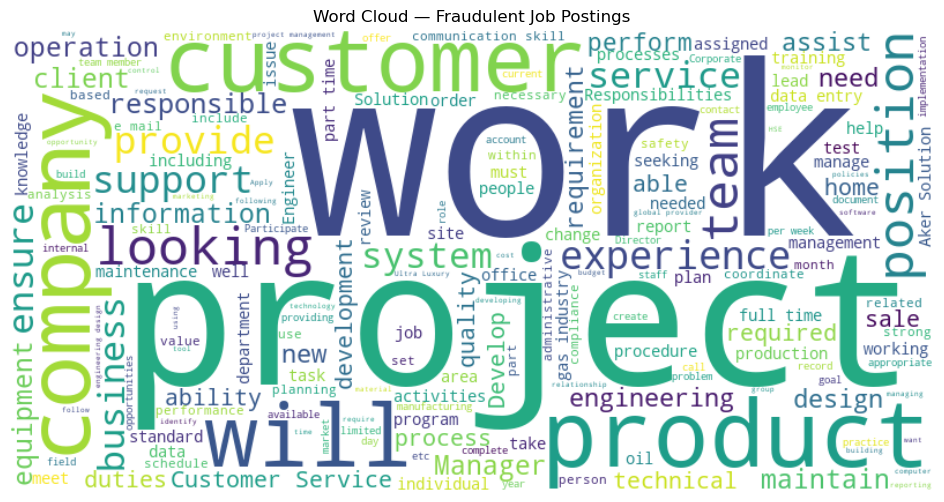

In [11]:
#Fake Word Cloud
fake_text = " ".join(fake_jobs)

wc_fake = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200
).generate(fake_text)

plt.figure(figsize=(14,6))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud — Fraudulent Job Postings")
plt.show()

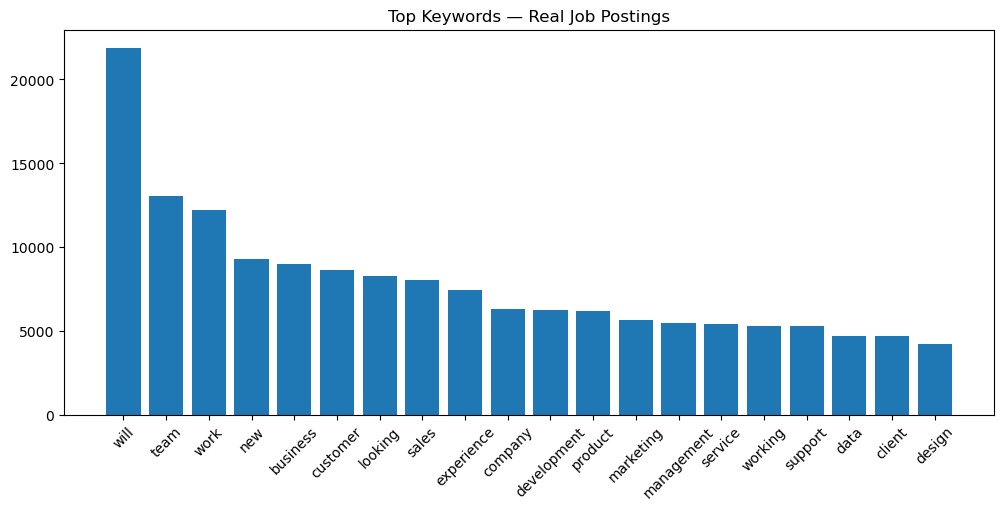

In [15]:
# Keyword Frequency

def get_top_words(text_series, n=20):
    words = " ".join(text_series).lower().split()
    words = [w for w in words if w.isalpha() and w not in STOPWORDS]
    return Counter(words).most_common(n)

real_top = get_top_words(real_jobs)

words, counts = zip(*real_top)

plt.figure(figsize=(12,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top Keywords — Real Job Postings")
plt.show()

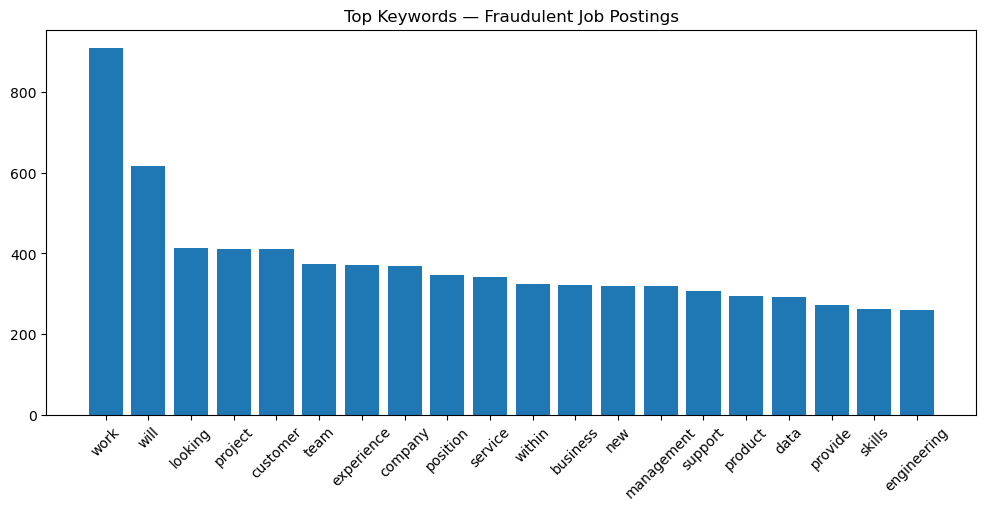

In [13]:
fake_top = get_top_words(fake_jobs)

words, counts = zip(*fake_top)

plt.figure(figsize=(12,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top Keywords — Fraudulent Job Postings")
plt.show()